<a href="https://colab.research.google.com/github/erictong0/FrederickLab2023/blob/main/Linear%20Regression/Initial%20defining%20regions/230626_Linear_regression_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# irrelevant

In [ ]:
#imports
!pip install bio --upgrade
!pip install scipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.4/276.4 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 31.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#imports for timing things
!pip install line_profiler
%load_ext line_profiler

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.9/661.9 kB 13.4 MB/s eta 0:00:00


In [ ]:
import sys
import glob
import math
import argparse
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as pltticker
from matplotlib.patches import Rectangle
import csv
from matplotlib import colors
import re
import pandas as pd
from numpy import savetxt
from sklearn.linear_model import LinearRegression
from statistics import mean
import statsmodels.api as sm
from Bio.Data.IUPACData import protein_letters_1to3 as one2three
import scipy.optimize as spo
from pandas.core.internals.construction import ma

In [ ]:
#works to load information in variables before the program

fwhm = 1.5  # Full width at half maximum
# Calculate the standard deviation from the FWHM
c = fwhm / (2 * np.sqrt(2 * np.log(2)))

def get_row_floats(data, row):
  return list(map(lambda x: float(x[row]), data))

xArray = []
for i in range(68):
  b = i / 4 + 54
  xArray.append(np.linspace(b - 3 * c, b + 3 * c, 100))

oData = []
data = []
with open("T_10K.out", mode="r") as infile: #open data file and read contents
  reader = csv.reader(infile, delimiter="\n")
  for row in reader:
    if len(row) == 1:
      data.append(re.split('\t', row[0])[2:])
    else:
      data.append(row)

tempData = []
for i in range(6):
  tempData.append(np.array(get_row_floats(data[1:], i)))

oData.append(tempData)

data = []
tempData = []
count = 0
with open("nanodisc.csv", mode="r") as infile: #open data file and read contents
  chunk_size = 1000
  while True:
      chunk = infile.readlines(chunk_size)
      if not chunk:
        break
      for line in chunk:
        reader = csv.reader(infile)
        for row in reader:
          count += 1
          if len(row) == 1:
            tempData.append(re.split(r',', row[0]))
          else:
            tempData.append(row)

data.append(get_row_floats(tempData,0))
data.append(get_row_floats(tempData,2))

oData.append(data)

DATAINPUT = oData

In [ ]:
def main(inData, aa, rangeChoices):
  aa1 = aa

  phi = inData[0][0]
  psi = inData[0][1]
  ca = inData[0][2]
  cb = inData[0][3]
  c = inData[0][4]
  n = inData[0][5]



  ca_exp = inData[1][0] #def x as Ca shift
  intensity = inData[1][1]



  atom_key={
            "ca":0,
            "cb":1,
            "co":2,
            "n":3,
          }

  nonCys_nonGly_aas={"A", "D", "E", "F", "H", "I", "K", "L", "M",
                    "N", "P", "Q", "R", "S", "T", "V", "Y", "W"}

  nonCys_aas={"A", "D", "E", "F", "G", "H", "I", "K", "L", "M",
              "N", "P", "Q", "R", "S", "T", "V", "Y", "W"}

  na=np.nan

  aa_spec_ranges={ #ranges of interest for chemical shifts
                  #aa1 Ca      Cb      C         N
                  # Ca & Cb adjusted to 17ppm to match Fig5
                 'A':[[11,28],[203,234],[170,184],[112,133]],
                  'R':[[47,64],[22,39],[169,183],[112,133]],
                  'N':[[44,61],[30,47],[168,182],[106,127]],
                  'D':[[45,62],[33,50],[169,183],[109,130]],
  #               'C':[[50,67],[22,39],[168,182],[105,126]],
                  'Q':[[47,64],[22,39],[169,183],[108,129]],
                  'E':[[49,66],[22,39],[169,183],[109,130]],
                  'G':[[36,53],[203,234],[167,181],[ 98,119]],
                  'H':[[49,66],[23,40],[168,182],[107,128]],
                  'I':[[54,71],[31,48],[168,182],[109,130]],
                  'L':[[45,62],[33,50],[170,184],[110,131]],
                  'K':[[49,66],[26,43],[169,183],[109,130]],
                  'M':[[47,64],[26,43],[169,183],[108,129]],
                  'F':[[50,67],[31,48],[168,182],[107,128]],
                  'P':[[57,74],[25,42],[170,184],[ na, na]],
                  'S':[[50,67],[105,139],[55,72],[167,181],[104,125]],
                  'T':[[54,71],[104,138],[60,77],[168,182],[102,123]],
                  'W':[[48,65],[21,38],[169,183],[109,130]],
                  'Y':[[50,67],[30,47],[168,182],[108,129]],
                  'V':[[54,71],[25,42],[169,183],[108,129]],
                  }

  ####Changed this part####
  rchoice = rangeChoices

  ### extract plot subregions ###
  # "r" stands for ramachandran
  # regions: beta-strand, polyproline helix ii
  #          beta-turn I, alpha-helix,
  #          left handed helix (all phi > 0)
  # !!! top and left corner are always >= or <=
  #     unless they reach the bottom/right axis
  #     (i.e. betaB, ppiiB, left)

  #filter beta regions
  mask1 = np.logical_and(phi >= rchoice['rbetaA'][0], phi <= rchoice['rbetaA'][1])
  mask1 = np.logical_and(mask1, psi >= rchoice['rbetaA'][2])
  mask1 = np.logical_and(mask1, psi <= rchoice['rbetaA'][3])

  mask2 = np.logical_and(phi >= rchoice['rbetaB'][0], phi <= rchoice['rbetaB'][1])
  mask2 = np.logical_and(mask2, psi >= rchoice['rbetaB'][2])
  mask2 = np.logical_and(mask2, psi <= rchoice['rbetaB'][3])

  mask = np.logical_or(mask1, mask2)

  data_beta_ca = ca[mask]
  data_beta_cb = cb[mask]
  data_beta_c = c[mask]
  data_beta_n = n[mask]

  #filter ppii regions
  mask1 = np.logical_and(phi >= rchoice['rppiiA'][0], phi <= rchoice['rppiiA'][1])
  mask1 = np.logical_and(mask1, psi >= rchoice['rppiiA'][2])
  mask1 = np.logical_and(mask1, psi <= rchoice['rppiiA'][3])

  mask2 = np.logical_and(phi >= rchoice['rppiiB'][0], phi <= rchoice['rppiiB'][1])
  mask2 = np.logical_and(mask2, psi >= rchoice['rppiiB'][2])
  mask2 = np.logical_and(mask2, psi <= rchoice['rppiiB'][3])

  mask = np.logical_or(mask1, mask2)

  data_ppii_ca = ca[mask]
  data_ppii_cb = cb[mask]
  data_ppii_c = c[mask]
  data_ppii_n = n[mask]

  #filter ddgg
  mask = np.logical_and(phi >= rchoice['rdelta'][0], phi <= rchoice['rdelta'][1])
  mask = np.logical_and(mask, psi >= rchoice['rdelta'][2])
  mask = np.logical_and(mask, psi <= rchoice['rdelta'][3])

  data_ddgg_ca = ca[mask]
  data_ddgg_cb = cb[mask]
  data_ddgg_c = c[mask]
  data_ddgg_n = n[mask]

  #filter turn
  mask1 = np.logical_and(phi >= rchoice['rturnI'][0], phi < rchoice['ralpha'][0])
  mask1 = np.logical_and(mask1, psi >= rchoice['rturnI'][2])
  mask1 = np.logical_and(mask1, psi <= rchoice['rturnI'][3])

  mask2 = np.logical_and(phi >= rchoice['ralpha'][1], phi < rchoice['rturnI'][1])
  mask2 = np.logical_and(mask2, psi >= rchoice['rturnI'][2])
  mask2 = np.logical_and(mask2, psi <= rchoice['rturnI'][3])

  mask3 = np.logical_and(phi >= rchoice['ralpha'][0], phi < rchoice['ralpha'][1])
  mask3 = np.logical_and(mask3, psi >= rchoice['rturnI'][2])
  mask3 = np.logical_and(mask3, psi <= rchoice['ralpha'][2])

  mask4 = np.logical_and(phi >= rchoice['ralpha'][0], phi < rchoice['ralpha'][1])
  mask4 = np.logical_and(mask4, psi > rchoice['ralpha'][3])
  mask4 = np.logical_and(mask4, psi <= rchoice['rturnI'][3])

  mask = np.logical_or(mask1, np.logical_or(mask2, np.logical_or(mask3, mask4)))
  data_turn_ca = ca[mask]
  data_turn_cb = cb[mask]
  data_turn_c = c[mask]
  data_turn_n = n[mask]

  #filter alph
  mask = np.logical_and(phi >= rchoice['ralpha'][0], phi < rchoice['ralpha'][1])
  mask = np.logical_and(mask, psi > rchoice['ralpha'][2])
  mask = np.logical_and(mask, psi <= rchoice['ralpha'][3])

  data_alph_ca = ca[mask]
  data_alph_cb = cb[mask]
  data_alph_c = c[mask]
  data_alph_n = n[mask]

  #filter left
  mask = np.logical_and(phi >= rchoice['rlhelx'][0], phi <= rchoice['rlhelx'][1])
  mask = np.logical_and(mask, psi >= rchoice['rlhelx'][2])
  mask = np.logical_and(mask, psi <= rchoice['rlhelx'][3])

  data_left_ca = ca[mask]
  data_left_cb = cb[mask]
  data_left_c = c[mask]
  data_left_n = n[mask]

  #filter zeta gamma
  mask = np.logical_and(phi >= rchoice['rzetag'][0], phi <= rchoice['rzetag'][1])
  mask = np.logical_and(mask, psi >= rchoice['rzetag'][2])
  mask = np.logical_and(mask, psi <= rchoice['rzetag'][3])

  data_zeta_ca = ca[mask]
  data_zeta_cb = cb[mask]
  data_zeta_c = c[mask]
  data_zeta_n = n[mask]

  # create dictionaries of data sets

  cs_ca = ({'beta': data_beta_ca,
            'ppii': data_ppii_ca,
            'ddgg': data_ddgg_ca,
            'left': data_left_ca,
            'turn': data_turn_ca,
            'alph': data_alph_ca,
            'zeta': data_zeta_ca,
            })
  cs_cb = ({'beta': data_beta_cb,
            'ppii': data_ppii_cb,
            'ddgg': data_ddgg_cb,
            'left': data_left_cb,
            'turn': data_turn_cb,
            'alph': data_alph_cb,
            'zeta': data_zeta_cb
            })
  cs_co = ({'beta': data_beta_c,
            'ppii': data_ppii_c,
            'ddgg': data_ddgg_c,
            'left': data_left_c,
            'turn': data_turn_c,
            'alph': data_alph_c,
            'zeta': data_zeta_c
            })

  cs_all = {'ca':cs_ca,
            'cb':cs_cb,
            'c' :cs_co,
            }

  bin_width=0.25
  mtick_spacing=5
  #fig, axs = plt.subplots(1, 1, sharey=False, tight_layout=True,figsize=(10,10)) #35826579

  x_lims = np.array(aa_spec_ranges[aa1][0])
  y_lims = np.array(aa_spec_ranges[aa1][1])
  x_edges = np.arange(x_lims[0],x_lims[1]+bin_width,bin_width) #create an array from one limit to the next using bin widths
  y_edges=np.arange(y_lims[0],y_lims[1]+bin_width,bin_width)
  hw=bin_width/2
  center_bins_x=np.arange(x_lims[0]+hw,x_lims[1]+hw,bin_width)
  center_bins_y=np.arange(y_lims[0]+hw,y_lims[1]+hw,bin_width)
  inputs = []
  h_lists = []
  h_list = []
  c = fwhm / (2 * np.sqrt(2 * np.log(2)))

  for key in cs_ca:
    H, bins = np.histogram(cs_ca[key],bins=(x_edges),density=False)
    for j in range(len(H)):
      a = H[j]  # Maximum value
      b = bins[j]  # Peak position

      x = xArray[round(b*4-216)]

      # Calculate the y values for the curve using the Gaussian function
      y = a * np.exp(-(x - b)**2 / (2 * c**2))
      histogram, bins = np.histogram(x, bins=x_edges, density=False, weights = y)
      h_list.append(histogram)
    h_lists = sum(h_list)
    inputs.append(h_lists)
    #h_lists = []
  #print(inputs)
  H_exp, bins = np.histogram(ca_exp,bins=(x_edges),density=False)
  target = (H_exp)

  tempSet = set(inputs)
  inputs = list(tempSet)

  data = {}
  for i in range(len(inputs)):
    data[f'x{i+1}'] = list(inputs[i])
  data['y'] = list(target)

  """hists1 = (inputs[0])
  hists2 = (inputs[1])
  hists3 = (inputs[2])
  hists4 = (inputs[3])
  hists5 = (inputs[4])
  hists6 = (inputs[5])
  hists7 = (inputs[6])
  #print(np.shape(inputs),len(inputs[0]),len(target))
  data = {'x1': list(hists1), 'x2': list(hists2), 'x3': list(hists3), 'x4':list(hists4), 'x5': list(hists5), 'x6':list(hists6), 'x7':list(hists7), 'y': list(target)}"""

  df = pd.DataFrame(data)
  x = df.drop('y', axis=1)
  y = df['y']

  model = sm.GLS(y,x)
  results = model.fit()
  return results




In [ ]:
def func3P(dict):
  r = main(DATAINPUT, "T", dict)
  #print(r.summary())
anotherdict = {'rbetaA': (-180.0, -77.24, 154.55, 180.0),
'rppiiA': (-77.24, 0, 154.55, 180.0),
'rzetag': (-180, 0, 60.45, 154.55),
'rdelta': (-180.0, 0, -41.04, 60.45),
'rturnI': (-180.0, 0, -162.7, -41.04),
'ralpha': (-40.21, -29.92, -80.25, -51.14),
'rbetaB': (-180.0, -112.55, -180.0, -162.7),
'rppiiB': (-112.55, 0, -180.0, -162.7),
'rlhelx': (0, 180.0, -180.0, 180.0)}

func3P(anotherdict)

NameError: ignored

In [ ]:
#makes a matplotlib rectangle object based on the coordinates of each corner.
def makeRect(s, c):
  return Rectangle((s[0], s[2]), s[1]-s[0], s[3]-s[2], color = c)

#takes a dictionary and plots all of the various rectangles
def visualizeRectangles(d, r2):
  fix, ax = plt.subplots()
  ax.add_patch(makeRect(d['rbetaA'], "#1a1b63"))
  ax.add_patch(makeRect(d['rbetaB'], "#1a1b63"))

  ax.add_patch(makeRect(d['rdelta'], "#b0e0fd"))

  ax.add_patch(makeRect(d['rturnI'], "#edaa38"))
  ax.add_patch(makeRect(d['ralpha'], "#a60002"))

  ax.add_patch(makeRect(d['rppiiA'], "#5e93da"))
  ax.add_patch(makeRect(d['rppiiB'], "#5e93da"))

  ax.add_patch(makeRect(d['rlhelx'], "#f3e6b7"))

  ax.add_patch(makeRect(d['rzetag'], "#004225"))

  bound = 200
  ax.set(xlim = (-1 * bound, bound), ylim = (-1*bound, bound))
  plt.title(f"R^2: {round(r2, 3)}")
  plt.show()

In [ ]:
#new code starts here
def returnDict2(params):
  topSep = params[0]
  topH = params[1]
  topMH = params[2]
  botMH = params[3]
  botSep = params[4]
  botH = params[5]
  boxL1 = params[6]
  boxL2 = params[7]
  boxH1 = params[8]
  boxH2 = params[9]
  L = 0
  return {
      #upper left
      'rbetaA':(-180.0, topSep, topH, 180.0),
      'rppiiA':( topSep,   L, topH, 180.0),

      #higher middle
      'rzetag':(-180, L,   topMH,   topH),

      #Middle
      'rdelta':(-180.0,   L,  botMH, topMH),

      #large middle box
      'rturnI':(-180.0,   L, botH,  botMH), # turn is wider alpha

      #smaller tiny box
      'ralpha':(boxL1, boxL2, boxH1, boxH2), # alph is strictly alpha

      #bottom left
      'rbetaB':(-180.0, botSep,-180.0, botH),
      'rppiiB':(botSep,    L,-180.0, botH),

      'rlhelx':(   L, 180.0,-180.0, 180.0),
  }

def func2(params):
  #topSep, topH, middleH, botSep, botH
  theDict = returnDict2(params)
  r = main(DATAINPUT, "T", theDict)
  #r.summary()
  return r.rsquared * -1

In [ ]:
def analyzeResults(result):
  if result[1] < result[2]:
    print('zetag/gamma separator is above betaA+ppiiA/zetag separator, make *aab* higher or *aac* lower')
    return False

  if result[2] < result[3]:
    print('delta/turn separator above zetag/delta separator, make *aac* higher or *aad* lower')
    return False

  if result[3] < result[5]:
    print('turn/betaB+ppiiB separator above delta/turn separator, make *aad* higher or *aaf* lower')
    return False

  if result[0] > 180:
    print('betaA+ppiiA separator above 180, make *aab* lower')
    return False

  if result[5] < -180:
    print('betaB/ppiiB separator below -180, make *aaf* higher')
    return False

  if result[6] < -180 or result[7] > 0:
    print('alpha box is horizontally out of bounds, potentially bad')
  if result[8] > result[3]:
    print('alpha box is above turn, potentially bad')
  if result[9] < result[5]:
    print('alpha box is below turn, potentially bad')
  return True

In [ ]:

def func2P(params):
  #topSep, topH, middleH, botSep, botH
  theDict = returnDict2(params)
  r = main(DATAINPUT, "T", theDict)
  #r.summary()
  print(r.summary())
  return r.rsquared * -1



In [ ]:
func2P([-77.24,154.55,60.45,-41.04,-112.55,-162.7,-40.21,-29.92,-80.25,-51.14]);

                                 GLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.628
Model:                            GLS   Adj. R-squared (uncentered):              0.592
Method:                 Least Squares   F-statistic:                              17.43
Date:                Mon, 26 Jun 2023   Prob (F-statistic):                    1.07e-11
Time:                        18:36:22   Log-Likelihood:                         -137.03
No. Observations:                  68   AIC:                                      286.1
Df Residuals:                      62   BIC:                                      299.4
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

# Relevant part


R^2 = 0.6955229867483885
-76.8,169.81,51.99,-51.1,-104.49,-172.23,-39.57,-26.62,-77.13,-53.85,
{'rbetaA': (-180.0, -76.80408965017523, 169.80870845791512, 180.0), 'rppiiA': (-76.80408965017523, 0, 169.80870845791512, 180.0), 'rzetag': (-180, 0, 51.98560244442456, 169.80870845791512), 'rdelta': (-180.0, 0, -51.09977304040835, 51.98560244442456), 'rturnI': (-180.0, 0, -172.23209531894375, -51.09977304040835), 'ralpha': (-39.574983433627146, -26.622800410917762, -77.1289326282625, -53.84712161823076), 'rbetaB': (-180.0, -104.49421796936058, -180.0, -172.23209531894375), 'rppiiB': (-104.49421796936058, 0, -180.0, -172.23209531894375), 'rlhelx': (0, 180.0, -180.0, 180.0)}


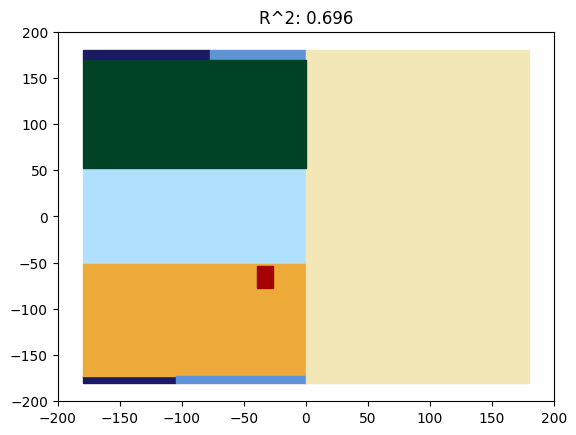

                                 GLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.696
Model:                            GLS   Adj. R-squared (uncentered):              0.666
Method:                 Least Squares   F-statistic:                              23.60
Date:                Mon, 26 Jun 2023   Prob (F-statistic):                    2.57e-14
Time:                        18:36:54   Log-Likelihood:                         -130.20
No. Observations:                  68   AIC:                                      272.4
Df Residuals:                      62   BIC:                                      285.7
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

-0.6955229867483885

In [ ]:
###############CHANGE THESE###############

#vertical separator between betaA and ppiiA
aaa = -77.31
#horizontal separator between betaA+ppiiA and zeta/gamma
aab = 154.64

#horizontal separator between zeta/gamma and delta
aac = 60
#horizontal separator between delta and turn
aad = -41

#vertical separator between betaB and ppiiB
aae = -112
#horizontal separator between turn and betaB+ppiiB
aaf = -161

##All of these are for the alpha helix (tiny red box) section
#left bound
aag = -40
#right bound
aah = -30
#bottom bound
aai = -80
#top bound
aaj = -51

#############DON'T CHANGE PAST THIS##############

guess = [aaa, aab, aac, aad, aae, aaf, aag, aah, aai, aaj]
result = spo.minimize(func2, guess,  method = 'Nelder-Mead')

#checks if results are valid boxes
if not analyzeResults(result.x):
  print("Invalid Results:")


print(f"R^2 = {result.fun * -1}")
for a in result.x:
  print(round(a, 2), end = ',')
print()

print(returnDict2(result.x))
visualizeRectangles(returnDict2(result.x), (result.fun * -1))

func2P(result.x)



# Irrelevant part again

In [ ]:
print(returnDict2([-77.24,154.55,60.45,-41.04,-112.55,-162.7,-40.21,-29.92,-80.25,-51.14]))

{'rbetaA': (-180.0, -77.24, 154.55, 180.0), 'rppiiA': (-77.24, 0, 154.55, 180.0), 'rzetag': (-180, 0, 60.45, 154.55), 'rdelta': (-180.0, 0, -41.04, 60.45), 'rturnI': (-180.0, 0, -162.7, -41.04), 'ralpha': (-40.21, -29.92, -80.25, -51.14), 'rbetaB': (-180.0, -112.55, -180.0, -162.7), 'rppiiB': (-112.55, 0, -180.0, -162.7), 'rlhelx': (0, 180.0, -180.0, 180.0)}


In [ ]:
#location of:
#vertical divider on top (x = -180:0), height of top section (y = 0:180), middle height (y = -90ish:90ish), vertical divider on bottom (x = -180:0), height of bottom section (y = -180)
#top vertical divider, top height, beta sheet vs zeta gamma, zeta gamma to turn, bottom divider, bottom height, alpha left, alpha right, alpha bottom, alpha top
#guess = [-80, 155, 120, 0, -80, -160, -40, -30, -100, -50]

In [ ]:
"""def returnDict(params):
  topSep = params[0]
  topH = params[1]
  middleH = params[2]
  botSep = params[3]
  botH = params[4]
  return {
      #upper left
      'rbetaA':(-180.0, topSep, topH, 180.0),
      'rppiiA':( topSep,   0.0, topH, 180.0),

      #Middle
      'rdelta':(-180.0,   0.0,  middleH, 105.0),

      #large middle box
      'rturnI':(-180.0,   0.0, botH,  middleH), # turn is wider alpha

      #smaller tiny box
      'ralpha':(-40, -35, -100, -50), # alph is strictly alpha

      #bottom left
      'rbetaB':(-180.0, botSep,-180.0, botH),
      'rppiiB':(botSep,    0.0,-180.0, botH),

      'rlhelx':(   0.0, 180.0,-180.0, 180.0),

      'rzetag':(-180,   0.0,   0.0,   120.0),
  }
def func(params):
  #topSep, topH, middleH, botSep, botH
  theDict = returnDict(params)
  r = main(DATAINPUT, "T", theDict)
  return r * -1
#vertical divider on top (x = -180:0), height of top section (y = 0:180), middle height (y = -90ish:90ish), vertical divider on bottom (x = -180:0), height of bottom section (y = -180:0)
guess = [-90, 150, 0, -90, -150]
#bounds = ((-116, -114), (129, 131), (-21, -19), (-146, -144), (-61, -59))
result = spo.minimize(func, guess, method = 'Nelder-Mead')
#result = spo.basinhopping(func, guess)
#print(result.x)
print(f"R^2 = {result.fun * -1}")
print(returnDict(result.x))"""

'def returnDict(params):\n  topSep = params[0]\n  topH = params[1]\n  middleH = params[2]\n  botSep = params[3]\n  botH = params[4]\n  return {\n      #upper left\n      \'rbetaA\':(-180.0, topSep, topH, 180.0),\n      \'rppiiA\':( topSep,   0.0, topH, 180.0),\n\n      #Middle\n      \'rdelta\':(-180.0,   0.0,  middleH, 105.0),\n\n      #large middle box\n      \'rturnI\':(-180.0,   0.0, botH,  middleH), # turn is wider alpha\n\n      #smaller tiny box\n      \'ralpha\':(-40, -35, -100, -50), # alph is strictly alpha\n\n      #bottom left\n      \'rbetaB\':(-180.0, botSep,-180.0, botH),\n      \'rppiiB\':(botSep,    0.0,-180.0, botH),\n\n      \'rlhelx\':(   0.0, 180.0,-180.0, 180.0),\n\n      \'rzetag\':(-180,   0.0,   0.0,   120.0),\n  }\ndef func(params):\n  #topSep, topH, middleH, botSep, botH\n  theDict = returnDict(params)\n  r = main(DATAINPUT, "T", theDict)\n  return r * -1\n#vertical divider on top (x = -180:0), height of top section (y = 0:180), middle height (y = -90ish:90is

In [ ]:
"""tempr = 0
for aaa in (-90, -160, -20):
  for bbb in (145, 90, 170):
    for ccc in (0, -90,  90):
      for ddd in (-90, -160,  -20):
        for eee in (-170, -145, -90):
          for fff in ( -40, -170, -120):
            for hhh in (-50, -150, -100):
              for jjj in (70, -10, 30):
                guess = [aaa, bbb, ccc, ddd, eee, fff, fff+40, hhh, hhh+40, jjj, jjj+40]
                result = spo.minimize(func2, guess,  method = 'Nelder-Mead')
                if result.fun * -1 > tempr:
                  tempr = result.fun * -1
                  print(f"New R: {tempr}\nDict:{returnDict2(result.x)}" )
#result = spo.basinhopping(func2, guess, niter = 1000, T = 10, stepsize = 5, disp = True)
#print(result.x)
print(f"R^2 = {result.fun * -1}")
print(returnDict2(result.x))"""

'tempr = 0\nfor aaa in (-90, -160, -20):\n  for bbb in (145, 90, 170):\n    for ccc in (0, -90,  90):\n      for ddd in (-90, -160,  -20):\n        for eee in (-170, -145, -90):\n          for fff in ( -40, -170, -120):\n            for hhh in (-50, -150, -100):\n              for jjj in (70, -10, 30):\n                guess = [aaa, bbb, ccc, ddd, eee, fff, fff+40, hhh, hhh+40, jjj, jjj+40]\n                result = spo.minimize(func2, guess,  method = \'Nelder-Mead\')\n                if result.fun * -1 > tempr:\n                  tempr = result.fun * -1\n                  print(f"New R: {tempr}\nDict:{returnDict2(result.x)}" )\n#result = spo.basinhopping(func2, guess, niter = 1000, T = 10, stepsize = 5, disp = True)\n#print(result.x)\nprint(f"R^2 = {result.fun * -1}")\nprint(returnDict2(result.x))'

In [ ]:
#aDict = returnDict([-120, 150, 0, -120, -90])

#%lprun -f main main(DATAINPUT, "T", aDict)

{'beta': [70.771, 69.778, 71.738, 72.77, 71.026, 69.534, 70.909, 69.989, 70.528, 71.835, 71.083, 72.248, 71.635, 71.132, 72.811, 73.027, 72.087, 71.081, 70.853, 70.113, 73.027, 70.467, 69.117, 70.336, 73.262, 67.531, 72.45, 69.957, 69.657, 68.847, 70.416, 73.144, 73.03, 69.468, 71.728, 68.241, 70.643, 71.832, 73.258, 70.543, 69.92, 70.26, 70.909, 70.394, 73.059, 70.572, 71.274, 72.872, 69.189, 72.587, 68.807, 63.714, 70.622, 73.389, 71.178, 73.26, 68.5, 72.748, 71.673, 70.275, 70.681, 70.749, 70.828, 71.972, 72.59, 73.461, 72.864, 71.252, 70.858, 70.975, 72.474, 73.589, 70.486, 73.328, 70.157, 72.451, 70.53, 70.07, 70.864, 70.996, 72.656, 73.464, 73.598, 70.759, 71.367, 70.484, 68.361, 73.385, 70.19, 71.968, 73.587, 70.265, 69.393, 71.871, 73.242, 70.393, 69.559, 73.182, 73.407, 70.617, 70.663, 72.034, 71.06, 70.831, 70.492, 73.199, 70.858, 70.358, 72.032, 73.48, 70.703, 65.977, 73.011, 73.609, 70.703, 72.852, 70.147, 71.303, 70.077, 70.38, 71.532, 70.342, 71.1, 70.732, 73.56, 71.675, 

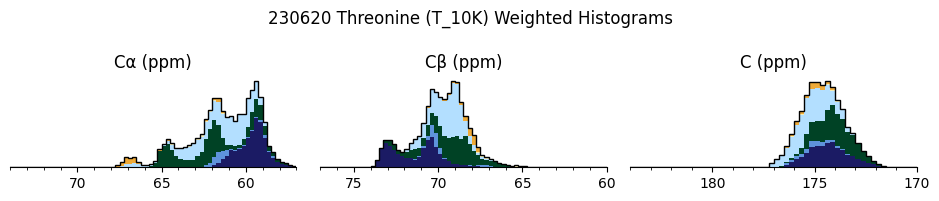

In [ ]:
#imports
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as pltticker
import numpy as np

#defining set things for proline
atoms = ['Cα', 'Cβ', 'C']
aa_range = [[57,74],[60, 77],[170,184]]
angles = {
'rbetaA': (-180.0, -77.2433806688377, 154.55177258517497, 180.0), 'rppiiA': (-77.2433806688377, 0, 154.55177258517497, 180.0), 'rzetag': (-180, 0, 60.44870313074169, 154.55177258517497), 'rdelta': (-180.0, 0, -41.0353713828222, 60.44870313074169), 'rturnI': (-180.0, 0, -162.70103742108336, -41.0353713828222), 'ralpha': (-40.21413124444349, -29.91741580348999, -80.2472522811782, -51.13859334954293), 'rbetaB': (-180.0, -112.55372675352831, -180.0, -162.70103742108336), 'rppiiB': (-112.55372675352831, 0, -180.0, -162.70103742108336), 'rlhelx': (0, 180.0, -180.0, 180.0)
}

#colors
colors = ['#1b1b64', '#5e93dc', "#004225", '#b3dfff', '#f3ecb7', '#eeaa38', '#a60000']

#reading the data
df = pd.read_csv('T_10K.out', sep = '\t', header = 0)
labels = ['beta','ppii','zetag','ddgg','left','turn','alph']

#making different variables based on each section

#delta, alpha, and left helix are easy: just get definitions
tempname = 'rdelta'
ddgg = df.loc[(df['phi'] >= angles[tempname][0]) & (df['phi'] < angles[tempname][1]) & (df['psi'] >= angles[tempname][2]) & (df['psi'] < angles[tempname][3])]
tempname = 'ralpha'
alph = df.loc[(df['phi'] >= angles[tempname][0]) & (df['phi'] < angles[tempname][1]) & (df['psi'] >= angles[tempname][2]) & (df['psi'] < angles[tempname][3])]
tempname = 'rlhelx'
left = df.loc[(df['phi'] >= angles[tempname][0]) & (df['phi'] < angles[tempname][1]) & (df['psi'] >= angles[tempname][2]) & (df['psi'] < angles[tempname][3])]
tempname = 'rzetag'
zetag = df.loc[(df['phi'] >= angles[tempname][0]) & (df['phi'] < angles[tempname][1]) & (df['psi'] >= angles[tempname][2]) & (df['psi'] < angles[tempname][3])]



#beta/ppii have both a top and bottom segment, so need to account for both top (A) and bottom (B) sections
tempname = 'rbeta'
beta = pd.concat([df.loc[(df['phi'] >= angles[tempname + "A"][0]) & (df['phi'] < angles[tempname + "A"][1]) & (df['psi'] >= angles[tempname + "A"][2]) & (df['psi'] < angles[tempname + "A"][3])], df.loc[(df['phi'] >= angles[tempname + "B"][0]) & (df['phi'] < angles[tempname + "B"][1]) & (df['psi'] >= angles[tempname + "B"][2]) & (df['psi'] < angles[tempname + "B"][3])]])
tempname = 'rppii'
ppii = pd.concat([df.loc[(df['phi'] >= angles[tempname + "A"][0]) & (df['phi'] < angles[tempname + "A"][1]) & (df['psi'] >= angles[tempname + "A"][2]) & (df['psi'] < angles[tempname + "A"][3])], df.loc[(df['phi'] >= angles[tempname + "B"][0]) & (df['phi'] < angles[tempname + "B"][1]) & (df['psi'] >= angles[tempname + "B"][2]) & (df['psi'] < angles[tempname + "B"][3])]])

#special case because turn needs to be everything except for the "alpha" section, used XOR but it might not work
tempname = 'rturnI'
tempname2 = 'ralpha'
turn = df.loc[((df['phi'] >= angles[tempname][0]) & (df['phi'] < angles[tempname][1]) & (df['psi'] >= angles[tempname][2]) & (df['psi'] < angles[tempname][3])) ^ ((df['phi'] >= angles[tempname2][0]) & (df['phi'] < angles[tempname2][1]) & (df['psi'] >= angles[tempname2][2]) & (df['psi'] < angles[tempname2][3]))]

#nice list to make future things easier
allsections = [beta, ppii, zetag, ddgg, left, turn, alph]
weights = [0.0065, 0.0047, 0.0047, -.0179, -.0405, 0.0326, 0.010]

for i in range(7):
  #print(allsections[i].dtypes)
  allsections[i].select_dtypes(exclude=['object', 'datetime']) * weights[i]
#makes the alpha/beta/overall carbon shifts into dictionaries based on the categories
ca = {}
cb = {}
co = {}
for i in range(7):
  ca[labels[i]] = allsections[i]['ca'].values.tolist()
  cb[labels[i]] = allsections[i]['cb'].values.tolist()
  co[labels[i]] = allsections[i]['c'].values.tolist()

#making pyplot figure
fig, axs = plt.subplots(1, 3, sharey = False, figsize = (9.5, 2))
fig.subplots_adjust(top = .9)

#makes an array for the future histogram categories
bins_array = [np.arange(i[0], i[1] + 1, .25) for i in aa_range]

#making total array
all = {'Cα': ca, 'Cβ' : cb, 'C' : co}

for i in range(3):
  h, bins, patches = axs[i].hist(list(all[atoms[i]].values()),
                      bins=bins_array[i],
                      density=False,
                      histtype='stepfilled',
                      stacked=True,
                      color=colors,
                      alpha=True,
                      label=labels)

  stacked_data = [j for sub in list(all[atoms[i]].values()) for j in sub]
  #print(stacked_data)
  axs[i].hist(stacked_data, # SUM PLOT: line histogram plot
              bins=bins_array[i],
              density=False,
              histtype='step',
              stacked=False,
              color='black',
              alpha=1.0)


  ### FORMATTING ###
  axs[i].set_xlim(aa_range[i])
  mtick_spacing=5
  axs[i].xaxis.set_major_locator(pltticker.MultipleLocator(mtick_spacing))
  axs[i].xaxis.set_minor_locator(pltticker.MultipleLocator(1))
  axs[i].yaxis.set_ticks([])
  axs[i].set_title(atoms[i] + " (ppm)")
  # other formatting
  axs[i].invert_xaxis()
  for line in ['top','left','right']:
    axs[i].spines[line].set_visible(False)
  for line in ['bottom']:
    axs[i].spines[line].set_visible(True)

print(cb)

fig.suptitle("230620 Threonine (T_10K) Weighted Histograms")
fig.tight_layout()
plt.show()

In [ ]:

#defining set things for proline
atoms = ['Cα', 'Cβ', 'C']
aa_range = [[57,74],[60, 77],[170,184]] #[54,71], [60,77], [168,182]
angles = {
'rbetaA': (-180.0, -77.2433806688377, 154.55177258517497, 180.0), 'rppiiA': (-77.2433806688377, 0, 154.55177258517497, 180.0), 'rzetag': (-180, 0, 60.44870313074169, 154.55177258517497), 'rdelta': (-180.0, 0, -41.0353713828222, 60.44870313074169), 'rturnI': (-180.0, 0, -162.70103742108336, -41.0353713828222), 'ralpha': (-40.21413124444349, -29.91741580348999, -80.2472522811782, -51.13859334954293), 'rbetaB': (-180.0, -112.55372675352831, -180.0, -162.70103742108336), 'rppiiB': (-112.55372675352831, 0, -180.0, -162.70103742108336), 'rlhelx': (0, 180.0, -180.0, 180.0)
}

#colors
colors = ['#1b1b64', '#5e93dc', "#004225", '#b3dfff', '#f3ecb7', '#eeaa38', '#a60000']

#reading the data
df = pd.read_csv('nanodisc.csv', sep = '\t', header = 0)
labels = ['beta','ppii','zetag','ddgg','left','turn','alph']

#making different variables based on each section

#delta, alpha, and left helix are easy: just get definitions
tempname = 'rdelta'
ddgg = df.loc[(df['phi'] >= angles[tempname][0]) & (df['phi'] < angles[tempname][1]) & (df['psi'] >= angles[tempname][2]) & (df['psi'] < angles[tempname][3])]
tempname = 'ralpha'
alph = df.loc[(df['phi'] >= angles[tempname][0]) & (df['phi'] < angles[tempname][1]) & (df['psi'] >= angles[tempname][2]) & (df['psi'] < angles[tempname][3])]
tempname = 'rlhelx'
left = df.loc[(df['phi'] >= angles[tempname][0]) & (df['phi'] < angles[tempname][1]) & (df['psi'] >= angles[tempname][2]) & (df['psi'] < angles[tempname][3])]
tempname = 'rzetag'
zetag = df.loc[(df['phi'] >= angles[tempname][0]) & (df['phi'] < angles[tempname][1]) & (df['psi'] >= angles[tempname][2]) & (df['psi'] < angles[tempname][3])]



#beta/ppii have both a top and bottom segment, so need to account for both top (A) and bottom (B) sections
tempname = 'rbeta'
beta = pd.concat([df.loc[(df['phi'] >= angles[tempname + "A"][0]) & (df['phi'] < angles[tempname + "A"][1]) & (df['psi'] >= angles[tempname + "A"][2]) & (df['psi'] < angles[tempname + "A"][3])], df.loc[(df['phi'] >= angles[tempname + "B"][0]) & (df['phi'] < angles[tempname + "B"][1]) & (df['psi'] >= angles[tempname + "B"][2]) & (df['psi'] < angles[tempname + "B"][3])]])
tempname = 'rppii'
ppii = pd.concat([df.loc[(df['phi'] >= angles[tempname + "A"][0]) & (df['phi'] < angles[tempname + "A"][1]) & (df['psi'] >= angles[tempname + "A"][2]) & (df['psi'] < angles[tempname + "A"][3])], df.loc[(df['phi'] >= angles[tempname + "B"][0]) & (df['phi'] < angles[tempname + "B"][1]) & (df['psi'] >= angles[tempname + "B"][2]) & (df['psi'] < angles[tempname + "B"][3])]])

#special case because turn needs to be everything except for the "alpha" section, used XOR but it might not work
tempname = 'rturnI'
tempname2 = 'ralpha'
turn = df.loc[((df['phi'] >= angles[tempname][0]) & (df['phi'] < angles[tempname][1]) & (df['psi'] >= angles[tempname][2]) & (df['psi'] < angles[tempname][3])) ^ ((df['phi'] >= angles[tempname2][0]) & (df['phi'] < angles[tempname2][1]) & (df['psi'] >= angles[tempname2][2]) & (df['psi'] < angles[tempname2][3]))]

#nice list to make future things easier
allsections = [beta, ppii, zetag, ddgg, left, turn, alph]

#makes the alpha/beta/overall carbon shifts into dictionaries based on the categories
ca = {}
cb = {}
co = {}
for i in range(7):
  ca[labels[i]] = allsections[i]['ca'].values.tolist()
  cb[labels[i]] = allsections[i]['cb'].values.tolist()
  co[labels[i]] = allsections[i]['c'].values.tolist()

#making pyplot figure
fig, axs = plt.subplots(1, 3, sharey = False, figsize = (9.5, 2))
fig.subplots_adjust(top = .9)

#makes an array for the future histogram categories
bins_array = [np.arange(i[0], i[1] + 1, .25) for i in aa_range]

#making total array
all = {'Cα': ca, 'Cβ' : cb, 'C' : co}

for i in range(3):
  h, bins, patches = axs[i].hist(list(all[atoms[i]].values()),
                      bins=bins_array[i],
                      density=False,
                      histtype='stepfilled',
                      stacked=True,
                      color=colors,
                      alpha=True,
                      label=labels)

  stacked_data = [j for sub in list(all[atoms[i]].values()) for j in sub]
  #print(stacked_data)
  axs[i].hist(stacked_data, # SUM PLOT: line histogram plot
              bins=bins_array[i],
              density=False,
              histtype='step',
              stacked=False,
              color='black',
              alpha=1.0)


  ### FORMATTING ###
  axs[i].set_xlim(aa_range[i])
  mtick_spacing=5
  axs[i].xaxis.set_major_locator(pltticker.MultipleLocator(mtick_spacing))
  axs[i].xaxis.set_minor_locator(pltticker.MultipleLocator(1))
  axs[i].yaxis.set_ticks([])
  axs[i].set_title(atoms[i] + " (deg)")
  # other formatting
  axs[i].invert_xaxis()
  for line in ['top','left','right']:
    axs[i].spines[line].set_visible(False)
  for line in ['bottom']:
    axs[i].spines[line].set_visible(True)

print(cb)

fig.suptitle("230620 Threonine (T_10K) Weighted Histograms")
fig.tight_layout()
plt.show()

KeyError: ignored